In [3]:
import pandas as pd
import numpy as np 
import yfinance as yf
import time
import datetime
import warnings
import matplotlib.pyplot as plt
#https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [111]:
def price_mage(ticker):
    while int(time.asctime().split()[3].replace(':','')) < 173000:
        test =  yf.download(tickers= ticker,interval ='5m',period = '1mo')
        today = test.loc[test.index >= (datetime.datetime.now()-datetime.timedelta(days=1)).strftime('%Y-%m-%d 09:30')]
        #Creating OBV
        #zip learned: https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel
        obv = []
        prev = 0
        obv_num = 0 
        for close,volume in  zip(test['Close'], test['Volume']):
            if close> prev:
                obv_num += volume
                prev = close
                obv.append(obv_num)
            elif close < prev:
                obv_num -= volume
                prev = close 
                obv.append(obv_num)
            else:
                obv.append(obv_num)
        test['OBV'] = obv
        
        #Creating By reccomendations for 30 minutes out
        Buy2 = np.where(test['Close'].shift(-6) > test['Close'],1,0)
        test['Buy'] = Buy2
        
        #Creating Rolling hour average
        test['Rolling_hour_average'] =test['Close'].rolling(12).mean()
        
        #Creating an above average column 
        test['Above_average'] = [1 if close > average else 0 for close,average in zip(test['Close'],test['Rolling_hour_average'])]
        
        #Creating an ADX Metric
        #Code and library adapted from https://blog.quantinsti.com/adx-indicator-python/
        high_low = []
        abs_high_prev = []
        abs_low_prev = []
        prev = 0
        for close,high,low in zip(test['Close'],test['High'],test['Low']):
            high_low.append(abs(high-low))
            abs_high_prev.append(abs(high-prev))
            abs_low_prev.append(abs(low-prev))
            prev = close 
        from ta.trend import ADXIndicator
        test['high_low'] = high_low
        test['abs_high_prev'] = abs_high_prev
        test['abs_low_prev'] = abs_low_prev
        adx = ADXIndicator(test['high_low'],test['abs_high_prev'],test['abs_low_prev'])
        test['adx'] = adx.adx()
        test.drop(columns= ['high_low','abs_high_prev','abs_low_prev'], inplace = True)
        
        #Creating a MACD
        #https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html
        from ta.trend import MACD
        Macd = MACD(test['Close'])
        test['MACD'] = Macd.macd()
        
        #Creating AroonIndicator
        #https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html
        from ta.trend import AroonIndicator
        aroon = AroonIndicator(test['Close'])
        test['Aroon_Indicator'] = aroon.aroon_indicator()
        
        #Dropping Nulls created from making Metrics 
        test.dropna(inplace = True)
        
        #Creating a Linear Regression predictions for 5 minute intervals out to 30 minutes into the future
        from sklearn.linear_model import LinearRegression
        lin_features = ['Volume','OBV', 'Rolling_hour_average', 'Above_average', 'adx','Aroon_Indicator', 'MACD','Close']
        forcast = test[lin_features][-6:]
        test['predictions'] = test['Close'].shift(-6)
        #print(test['predictions'].tail(15))
        lin_test = test.dropna()
        lin_X = lin_test[lin_features]
        lin_y = lin_test['predictions']
        X_train, X_test, y_train, y_test = train_test_split(lin_X,lin_y, train_size=.7, random_state = 6)

        lin_model = LinearRegression()
        lin_model.fit(X_train,y_train)
        #print(f'Accuracy: {lin_model.score(X_test,y_test)}')
        forcast['predictions'] = lin_model.predict(forcast)
        forcast['Lin Model Accuracy'] = lin_model.score(X_test,y_test)

        
        #Resetting times to forcast
        changer = forcast.index.to_pydatetime()
        changer = [x+datetime.timedelta(minutes=30) for x in changer]
        forcast.index = pd.DatetimeIndex(changer)
        #print(forcast['predictions'])
        
        #Code adapted from lesson 6.05
        from sklearn.svm import SVC
        from sklearn.preprocessing import StandardScaler
        #Turn this into a classification network
        #This was inspired from https://www.cs.princeton.edu/sites/default/files/uploads/saahil_madge.pdf
        SVC_model = SVC()
        sc = StandardScaler()
        SVC_features = ['Volume','OBV', 'Rolling_hour_average', 'Above_average', 'adx','Aroon_Indicator', 'MACD','Close']
        SVC_X = test[SVC_features]
        SVC_X_scaled = sc.fit_transform(SVC_X)
        SVC_y = test['Buy']
        X_train, X_test, y_train, y_test = train_test_split(SVC_X_scaled,SVC_y, train_size=.7, random_state = 6)
        SVC_model = SVC_model.fit(X_train,y_train)
        forcast['SVC_UpValue_Predictions'] = SVC_model.predict(forcast.drop(columns=['predictions','Lin Model Accuracy']))
        forcast['SVC Accuracy'] = SVC_model.score(X_test,y_test)
        #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html
        forcast['SVC_Recommendation'] = forcast['SVC_UpValue_Predictions'].map({1:'Buy',0:'Sell'})
        forcast.drop(columns=['Volume', 'OBV', 'Rolling_hour_average', 'Above_average', 'adx',
                              'Aroon_Indicator', 'MACD', 'Close','SVC_UpValue_Predictions'],inplace=True)
        
        forcast['Ticker'] = stock
        #Creating CSV
        forcast.to_csv('Data\Trade_Recommendations.csv')
        
        #learned from https://stackoverflow.com/questions/204017/how-do-i-execute-a-program-from-python-os-system-fails-due-to-spaces-in-path
        
        
        
        
        
        max_tick = int(today['Close'].mean() +20)
        min_tick = int(today['Close'].mean() -20)
        y_ticks = list(range(min_tick,max_tick,5))
        plt.figure(figsize=(10,10))
        plt.plot_date(today.index.to_pydatetime(), today['Close'],color= 'b')
        plt.plot_date(forcast.index.to_pydatetime(), forcast['predictions'],color= 'g')
        plt.plot(today.index.to_pydatetime(), today['Close'],color= 'b')
        plt.plot(forcast.index.to_pydatetime(), forcast['predictions'],color= 'g')
        plt.ylabel('Stock Price',fontsize= 15)
        plt.yticks(y_ticks)
        plt.xlabel('Time', fontsize = 15)
        plt.title(f'{stock} Current and Project Price')
        plt.show()
        
        
        
        
        
        import os
        os.popen("Data\Trade_Recommendations.csv")
        
        time.sleep(30)
        

Please enter in a stock ticker in all caps: AAPL


[*********************100%***********************]  1 of 1 completed


KeyboardInterrupt: 

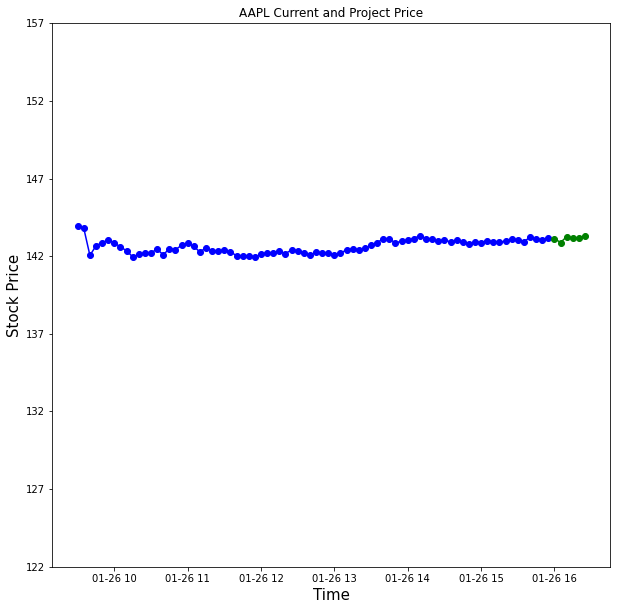

In [112]:
stock = str(input(prompt='Please enter in a stock ticker in all caps:'))
price_mage(stock)